<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/Anomaly_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anomaly detection using Auto Encoder (AE):
MNIST dataset of hand written digit has been used. I have dropped 4,5,6 from MNIST training dataset and labelled training dataset as background (bkg). The AE will be trained using bkg data. The anomaly will be tested in test dataset which will have 4,5,6 as anomaly.

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split

# this is the size of our encoded representations
encoding_dim = 32  
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [122]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [123]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loading MNIST handwritten digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [125]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
# Making bkg training data by dropping 4, 5 and 6
x_train_bkg = x_train[np.where((y_train!=4)&(y_train!=5)&(y_train!=6))]

In [127]:
x_train_bkg.shape

(42819, 784)

In [0]:
# separating training data as train and validation set
x_train_bkg,valid_x_train_bkg = train_test_split(x_train_bkg,
                                                 test_size=0.2, 
                                                 random_state=13)

In [129]:
autoencoder_train = autoencoder.fit(x_train_bkg, x_train_bkg,
                                epochs=50,
                                batch_size=256,
                                shuffle=True,
                                validation_data=(valid_x_train_bkg, valid_x_train_bkg))

Train on 34255 samples, validate on 8564 samples
Epoch 1/50
34255/34255 [==============================] - 1s 31us/step - loss: 0.0693 - val_loss: 0.0422
Epoch 2/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0340 - val_loss: 0.0285
Epoch 3/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0254 - val_loss: 0.0228
Epoch 4/50
34255/34255 [==============================] - 1s 29us/step - loss: 0.0212 - val_loss: 0.0196
Epoch 5/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0184 - val_loss: 0.0174
Epoch 6/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0166 - val_loss: 0.0162
Epoch 7/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0153 - val_loss: 0.0148
Epoch 8/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0143 - val_loss: 0.0139
Epoch 9/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0135 - val_loss: 0.0133
Epoch 

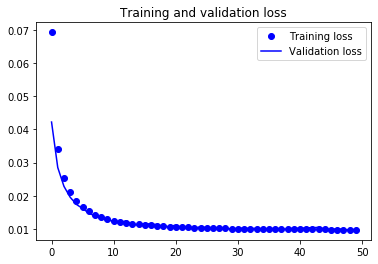

In [130]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Building truth label for test data; e.g. example containing 4,5,6 will be labelled as '1' and rest of the example will be labelled as '0'

In [0]:
truth = np.zeros(len(y_test))
truth[np.where((y_test==4)|(y_test==5)|(y_test==6))]= 1

In [0]:
predict_nums=autoencoder.predict(x_test)

In [133]:
predict_nums.shape

(10000, 784)

Using reconstruction error MSE to separate signal(anomaly) and bkg

In [0]:
predict_loss_mse = np.mean(np.power(x_test - predict_nums, 2), axis =1)

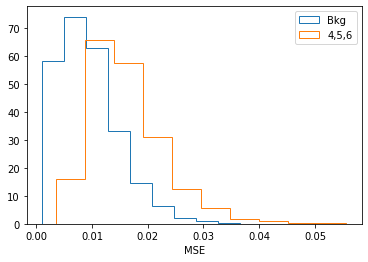

In [136]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg', density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6', density=True)
plt.legend(loc='best')
plt.xlabel('MSE')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


roc_auc = 0.803720075531868


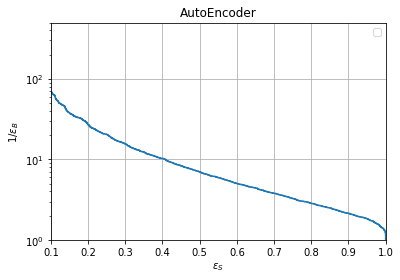

In [137]:
# ROC & AUC
fpr, tpr, thrs = roc_curve(truth, predict_loss_mse)
print("roc_auc =", roc_auc_score(truth, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

t-SNE plot for a better visualization of encoded/latent representation of test data

In [0]:
# Utility function to visualize the outputs of PCA and t-SNE

def num_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
# Dataset at the encoded layer
encoded_test = encoder.predict(x_test)
encoded_train_bkg = encoder.predict(x_train_bkg)

In [140]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
RS = 123
fashion_tsne = TSNE(random_state=RS).fit_transform(encoded_test)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 96.811842918396 seconds


In [0]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.patheffects as PathEffects

Representing all the class present in the test sample at the latent space

(<Figure size 576x576 with 1 Axes>,
 [Text(49.166664, 44.65413, '0'),
  Text(-55.79297, 31.10284, '1'),
  Text(31.623009, -19.854296, '2'),
  Text(29.818, 12.781395, '3'),
  Text(-34.309822, -37.7264, '4'),
  Text(0.7907622, 9.052399, '5'),
  Text(-3.54073, 59.69157, '6'),
  Text(-10.516626, -25.791786, '7'),
  Text(30.296831, -41.93467, '8'),
  Text(-26.212257, -52.78174, '9')])

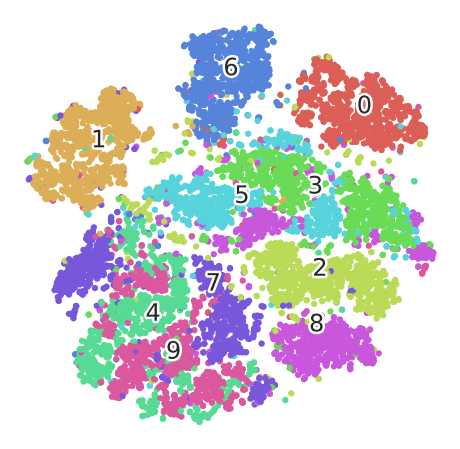

In [142]:
num_scatter(fashion_tsne, y_test)

Representing as binary class that is signal and bkg at the latent space

(<Figure size 576x576 with 1 Axes>,
 [Text(10.172286, -6.4448376, '0'), Text(-10.501477, 8.824459, '1')])

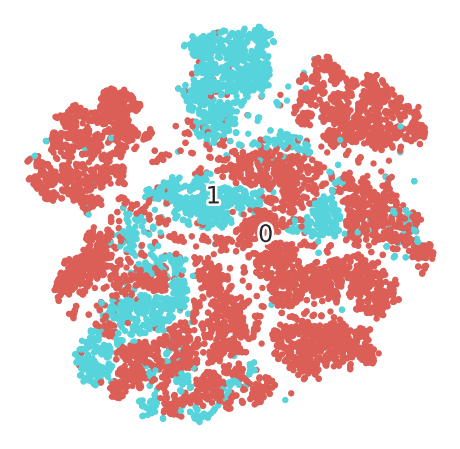

In [143]:
num_scatter(fashion_tsne, truth)

Also used kMeans, not sure how efficient it would be in labelling signal (1) and bkg (0) but as an unsupervised learning algorithm why not.

In [0]:
from sklearn.cluster import KMeans

In [145]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(encoded_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
truth_kmeans = Kmean.labels_

In [147]:
truth_kmeans.shape

(10000,)

Here would like inform the MSE error is the same as calculated before but plotting with respect to '0', '1' labels generated by kMeans algorithm

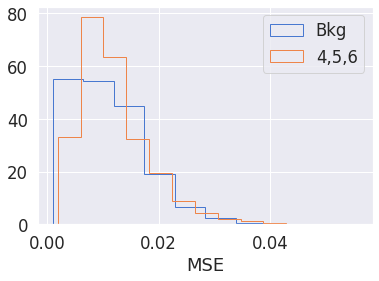

In [148]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth_kmeans[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg',density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6',density=True)
plt.legend(loc='best')
plt.xlabel('MSE')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


roc_auc = 0.5502851259814237


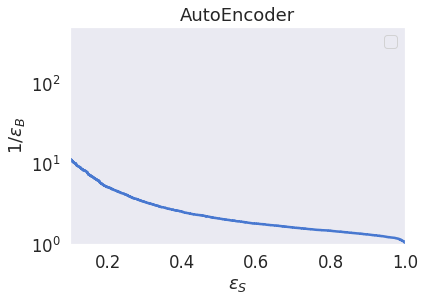

In [149]:
fpr, tpr, thrs = roc_curve(truth_kmeans, predict_loss_mse)
print("roc_auc =", roc_auc_score(truth_kmeans, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

(<Figure size 576x576 with 1 Axes>,
 [Text(-22.227566, 4.6501236, '0'), Text(39.178482, -3.185165, '1')])

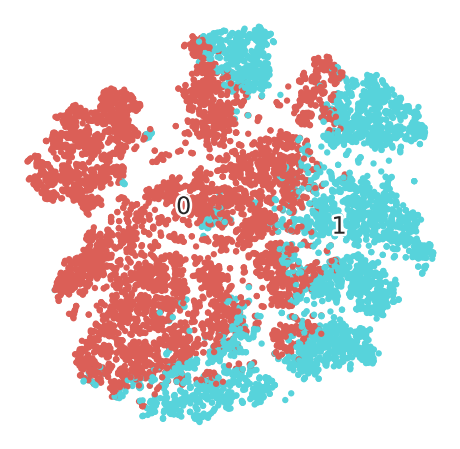

In [150]:
num_scatter(fashion_tsne, truth_kmeans)

Last but not the least, LSH or locality sensitive hashing: The hashing technique divides latent space in no. of random planes (hash_size) and each training datapoint projected in latent space gets hash key depending on its position w.r.t all the hash planes. Then we check posotion of test data in latent space if the hash key generated for test data matches with train data then its a bkg in test dataset else its anomaly/signal

In [0]:
hash_size = 20
sample_size, vec_size = encoded_train_bkg.shape
projections = np.random.randn(hash_size, vec_size)

In [0]:
hashed_encoded = list()

In [0]:
for i in range(sample_size):
  bools = ''
  for j in range(hash_size):
    bool = (np.dot(encoded_train_bkg[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
    #print(bools)
  hashed_encoded.append(bools)

In [154]:
len(hashed_encoded)

34255

In [0]:
def getDuplicatesWithInfo(hashed_encoded):
    ''' Get duplicate element in a list along with thier indices in list
     and frequency count'''
    dictOfElems = dict()
    index = 0
    # Iterate over each element in list and keep track of index
    for elem in hashed_encoded:
        # If element exists in dict then keep its index in lisr & increment its frequency
        if elem in dictOfElems:
            dictOfElems[elem][0] += 1
            dictOfElems[elem][1].append(index)
        else:
            # Add a new entry in dictionary 
            dictOfElems[elem] = [1, [index]]
        index += 1    
 
    dictOfElems = { key:value for key, value in dictOfElems.items() }
    return dictOfElems

In [0]:
dictOfElems = getDuplicatesWithInfo(hashed_encoded)
listHash = list()
for key, value in dictOfElems.items():
  listHash.append(key)
  #print('Element = ', key , ' :: Repeated Count = ', value[0] , ' :: Index Positions =  ', value[1])    

In [0]:
 listHash = np.array(listHash)

In [0]:
tableSize= len(listHash)

In [0]:
sample_size, vec_size = encoded_test.shape

In [0]:
hash_truth = list()

In [166]:
count = 0
for i in range(sample_size):
  bools = ''
  a = 1
  for j in range(hash_size):
    bool = (np.dot(encoded_test[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
  #print(bools)
  for k in range(tableSize):
    #print("bools: ",bools)
    #print("listHash: ", listHash[k])
    if bools == listHash[k]:
      #print("listHash: ", listHash[k])
      a=0
      #print(a)
      break
  #count = 0
  if(a==1):
    count+=1
    #print(a)
  #print(count)
  hash_truth.append(a)
print(count)

108


Here would like inform the MSE error is the same as calculated before but plotting with respect to '0', '1' labels generated by LSH algorithm

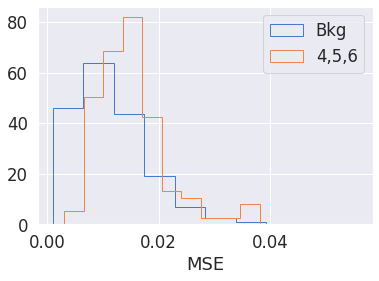

In [167]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if hash_truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg',density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6',density=True)
plt.legend(loc='best')
plt.xlabel('MSE')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.6841340177622022


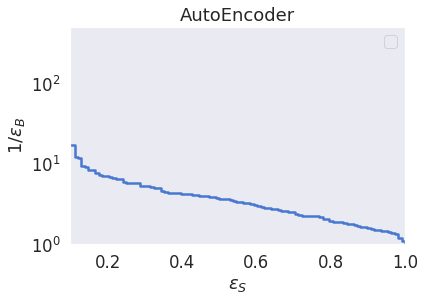

In [169]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(hash_truth, predict_loss_mse)
print("roc_auc =", roc_auc_score(hash_truth, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()